## Import Library

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
import gdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

print("✅ Libraries Imported Successfully")

✅ Libraries Imported Successfully


## Memory Optimization Function

In [55]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


## Load Data

In [56]:
# ID file dari Google Drive
train_id = '1vA9rGGPElhn7rARS1qJyIAUJDny36mhy'
test_id = '182S6yNqDfluSw6FIvya5ZGD-3ia963Lx'

# Download datasets
print("⬇️ Downloading datasets...")
gdown.download(id=train_id, output='train_transaction.csv', quiet=False)
gdown.download(id=test_id, output='test_transaction.csv', quiet=False)

# Load Data
print("\n📂 Loading Train Data...")
train = pd.read_csv('train_transaction.csv')
train = reduce_mem_usage(train)

print("\n📂 Loading Test Data...")
test = pd.read_csv('test_transaction.csv')
test = reduce_mem_usage(test)

print(f"\n✅ Train Shape: {train.shape}")
print(f"✅ Test Shape: {test.shape}")

# Hapus variabel yang tidak perlu untuk menghemat memori
gc.collect()

⬇️ Downloading datasets...


Downloading...
From (original): https://drive.google.com/uc?id=1vA9rGGPElhn7rARS1qJyIAUJDny36mhy
From (redirected): https://drive.google.com/uc?id=1vA9rGGPElhn7rARS1qJyIAUJDny36mhy&confirm=t&uuid=cfef0cfc-f61e-4ac6-868e-3713f55e9dfa
To: c:\Users\HP Pavilion 15\Documents\ML\UTS\midterm_folder\train_transaction.csv
100%|██████████| 683M/683M [01:02<00:00, 10.9MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=182S6yNqDfluSw6FIvya5ZGD-3ia963Lx
From (redirected): https://drive.google.com/uc?id=182S6yNqDfluSw6FIvya5ZGD-3ia963Lx&confirm=t&uuid=545740b7-003d-43b0-bca0-5dc3edccadcc
To: c:\Users\HP Pavilion 15\Documents\ML\UTS\midterm_folder\test_transaction.csv
100%|██████████| 613M/613M [00:55<00:00, 11.0MB/s] 



📂 Loading Train Data...
Mem. usage decreased to 542.35 Mb (69.4% reduction)

📂 Loading Test Data...
Mem. usage decreased to 472.59 Mb (68.9% reduction)

✅ Train Shape: (590540, 394)
✅ Test Shape: (506691, 393)


8873

## Exploratory Data Analysis (EDA)

📊 Target Distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64

📊 Missing Values (Top 10):
dist2    93.628374
D7       93.409930
D13      89.509263
D14      89.469469
D12      89.041047
D6       87.606767
D9       87.312290
D8       87.312290
V153     86.123717
V149     86.123717
dtype: float64


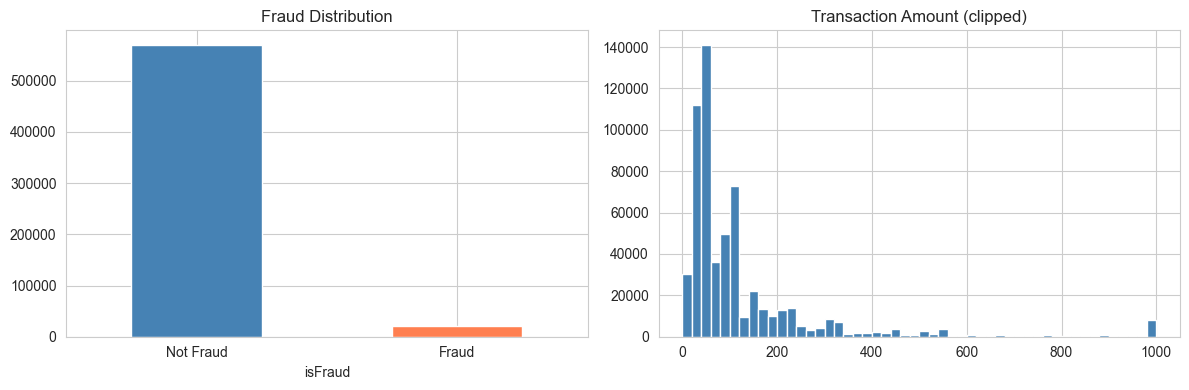

In [57]:
# --- 1. Menampilkan Statistik Teks (Target Distribution & Missing Values) ---
print("📊 Target Distribution:")
print(train['isFraud'].value_counts())

print("\n📊 Missing Values (Top 10):")
# Menghitung persentase missing value per kolom
missing = (train.isnull().sum() / len(train) * 100).sort_values(ascending=False)
print(missing.head(10))

# --- 2. Membuat 2 Grafik Berdampingan (Subplots) ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4)) # Membuat layout 1 baris, 2 kolom

# Grafik 1: Fraud Distribution (Bar Chart)
# Menggunakan pandas plot agar mirip referensi
train['isFraud'].value_counts().plot(kind='bar', ax=ax[0], color=['steelblue', 'coral'])
ax[0].set_title('Fraud Distribution')
ax[0].set_xticklabels(['Not Fraud', 'Fraud'], rotation=0)
ax[0].set_xlabel('isFraud')

# Grafik 2: Transaction Amount (Histogram)
# Kita clip/batasi di 1000 agar histogram tidak "gepeng" karena outliers (transaksi miliaran)
train['TransactionAmt'].clip(upper=1000).hist(bins=50, ax=ax[1], color='steelblue')
ax[1].set_title('Transaction Amount (clipped)')

# Menampilkan plot
plt.tight_layout()
plt.show()

## Feature Engineering

In [58]:
import numpy as np 

def engineer_features(df):
    # Cek apakah kolom TransactionDT ada
    if 'TransactionDT' not in df.columns:
        return df # Kembalikan dataframe apa adanya jika kolom sudah tidak ada

    # 1. Time Features
    df['hour'] = (df['TransactionDT'] // 3600) % 24
    df['day'] = (df['TransactionDT'] // (3600 * 24)) % 7
    
    # 2. Transaction Amount Features
    df['TransactionAmt_Log'] = np.log1p(df['TransactionAmt'])
    
    # Ambil bagian desimal
    df['TransactionAmt_decimal'] = (df['TransactionAmt'] - df['TransactionAmt'].fillna(0).astype(int)).astype('float32')
    
    # 3. Email Mapping
    emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
              'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
              'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
              'yahoo.es': 'yahoo', 'yahoo.de': 'yahoo', 'live.com.mx': 'microsoft',
              'me.com': 'apple', 'icloud.com': 'apple', 'mac.com': 'apple'}
    
    for c in ['P_emaildomain', 'R_emaildomain']:
        if c in df.columns:
            df[c] = df[c].map(emails).fillna(df[c])
        
    return df

print("⚙️ Engineering features...")

# Cek dulu apakah data masih memiliki TransactionDT sebelum diproses
if 'TransactionDT' in train.columns:
    train = engineer_features(train)
    test = engineer_features(test)

    # Drop kolom TransactionDT asli HANYA jika masih ada
    train.drop('TransactionDT', axis=1, inplace=True)
    test.drop('TransactionDT', axis=1, inplace=True)
    print("✅ Fitur baru berhasil dibuat dan TransactionDT dihapus.")
else:
    print("⚠️ Kolom 'TransactionDT' sudah tidak ada (mungkin sel ini dijalankan 2x).")
    print("   Data diasumsikan sudah diproses sebelumnya.")

# Tampilkan contoh data untuk memastikan
print("\nContoh data hasil engineering:")
cols_to_show = ['TransactionAmt', 'hour', 'day', 'TransactionAmt_Log']
# Hanya tampilkan kolom yang benar-benar ada di dataframe
cols_to_show = [c for c in cols_to_show if c in train.columns]
print(train[cols_to_show].head())

⚙️ Engineering features...
✅ Fitur baru berhasil dibuat dan TransactionDT dihapus.

Contoh data hasil engineering:
   TransactionAmt  hour  day  TransactionAmt_Log
0            68.5     0    1            4.242188
1            29.0     0    1            3.400391
2            59.0     0    1            4.093750
3            50.0     0    1            3.931641
4            50.0     0    1            3.931641


## Handling Missing Values & Encoding

In [59]:
# Memisahkan Target dan Fitur
X = train.drop(['isFraud', 'TransactionID'], axis=1)
y = train['isFraud']
X_test = test.drop('TransactionID', axis=1)
test_ids = test['TransactionID']

del train, test
gc.collect()

cat_cols = X.select_dtypes(include=['object']).columns

print("🔄 Preprocessing Data...")

for col in X.columns:
    # 1. Jika kolom kategorikal
    if col in cat_cols:
        X[col] = X[col].fillna('unknown')
        X_test[col] = X_test[col].fillna('unknown')
        
        le = LabelEncoder()
        le.fit(list(X[col].astype(str).values) + list(X_test[col].astype(str).values))
        X[col] = le.transform(list(X[col].astype(str).values))
        X_test[col] = le.transform(list(X_test[col].astype(str).values))
    
    # 2. Jika kolom nimerikal
    else:
        X[col] = X[col].fillna(-999)
        X_test[col] = X_test[col].fillna(-999)

print("✅ Preprocessing Done")

# 1. Cek apakah masih ada missing values
missing_count = X.isnull().sum().sum()
print(f"\nSisa Missing Values: {missing_count}")

# 2. Tampilkan data yang sudah berubah jadi angka semua
print("Contoh data setelah Encoding:")
print(X.head())

🔄 Preprocessing Data...
✅ Preprocessing Done

Sisa Missing Values: 0
Contoh data setelah Encoding:
   TransactionAmt  ProductCD  card1  card2  card3  card4  card5  card6  addr1  \
0            68.5          4  13926 -999.0  150.0      1  142.0      1  315.0   
1            29.0          4   2755  404.0  150.0      2  102.0      1  325.0   
2            59.0          4   4663  490.0  150.0      4  166.0      2  330.0   
3            50.0          4  18132  567.0  150.0      2  117.0      2  476.0   
4            50.0          1   4497  514.0  150.0      2  102.0      1  420.0   

   addr2  dist1  dist2  P_emaildomain  R_emaildomain   C1   C2   C3   C4   C5  \
0   87.0   19.0 -999.0             44             44  1.0  1.0  0.0  0.0  0.0   
1   87.0 -999.0 -999.0             15             44  1.0  1.0  0.0  0.0  0.0   
2   87.0  287.0 -999.0             31             44  1.0  1.0  0.0  0.0  0.0   
3   87.0 -999.0 -999.0             51             44  2.0  5.0  0.0  0.0  0.0   
4   87.0 

## Model Training (LightGBM)

In [60]:
# Split Train (80%) dan Validation (20%)
# Stratify=y memastikan proporsi fraud sama di kedua set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Hitung bobot kelas untuk imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# Konfigurasi Hyperparameter LightGBM
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 2000,
    'learning_rate': 0.05,
    'num_leaves': 64,
    'max_depth': -1,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'scale_pos_weight': scale_pos_weight,  # Handle Imbalance
    'n_jobs': -1,
    'random_state': 42
}

print("🚀 Starting Training...")
model = lgb.LGBMClassifier(**lgb_params)

# Training dengan Early Stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)]
)

print("✅ Training Finished")

Calculated scale_pos_weight: 27.58
🚀 Starting Training...
[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.302304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36885
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 394
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.966898	valid_1's auc: 0.945974
[400]	training's auc: 0.981446	valid_1's auc: 0.955472
[600]	training's auc: 0.988811	valid_1's auc: 0.960524
[800]	training's auc: 0.992704	valid_1's auc: 0.963644
[1000]	training's auc: 0.995112	valid_1's auc: 0.965558
[1200]	training's auc: 0.996608	valid_1's 

## Evaluation


🌟 Validation ROC-AUC Score: 0.9682

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    113975
           1       0.58      0.81      0.67      4133

    accuracy                           0.97    118108
   macro avg       0.79      0.89      0.83    118108
weighted avg       0.98      0.97      0.97    118108



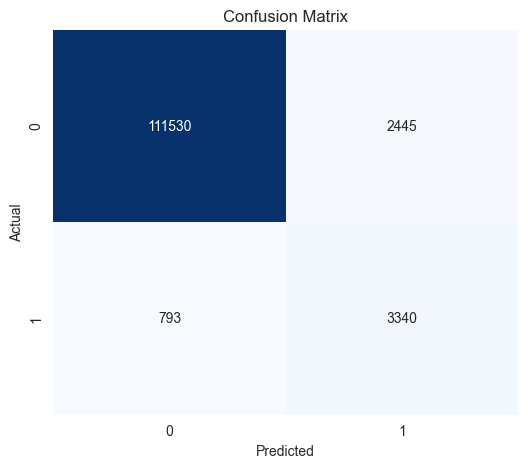

<Figure size 1000x800 with 0 Axes>

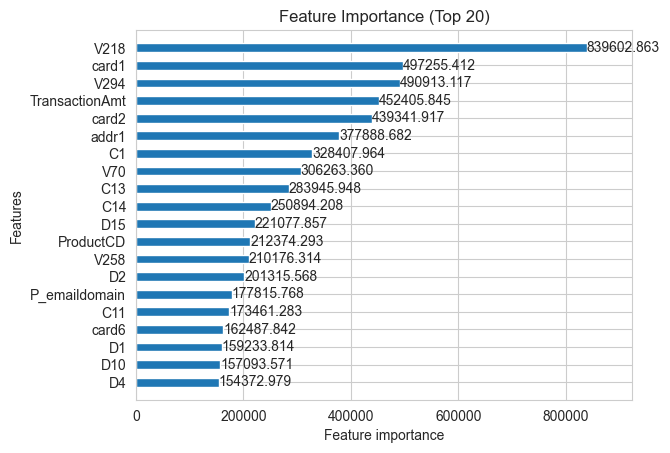

In [61]:
# Prediksi
y_pred_prob = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)

# 1. ROC-AUC Score
auc_score = roc_auc_score(y_val, y_pred_prob)
print(f"\n🌟 Validation ROC-AUC Score: {auc_score:.4f}")

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# 3. Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 4. Feature Importance
plt.figure(figsize=(10, 8))
lgb.plot_importance(model, max_num_features=20, height=0.5, title='Feature Importance (Top 20)', importance_type='gain')
plt.show()

## Submission

In [62]:
print("🔮 Predicting on Test set...")
test_pred_prob = model.predict_proba(X_test)[:, 1]

# Membuat DataFrame Submission
submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': test_pred_prob
})

# Simpan ke CSV
submission.to_csv('submission.csv', index=False)

print("✅ submission.csv created successfully!")
print(submission.head())    

🔮 Predicting on Test set...
✅ submission.csv created successfully!
   TransactionID   isFraud
0        3663549  0.005926
1        3663550  0.000862
2        3663551  0.004409
3        3663552  0.007258
4        3663553  0.001388
